In [1]:
pip install emoji==1.7.0

Note: you may need to restart the kernel to use updated packages.


# Importing necessary libraries

In [2]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# Preparation and reading data

In [3]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr': '%m/%d/%y, %I:%M %p - ',
        '24hr': '%m/%d/%y, %H:%M - ',
        'custom': ''
    }
        
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [4]:
df = rawToDf('WhatsApp_chat.txt', '12hr')

# Pre-processing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  1268 non-null   datetime64[ns]
 1   user       1268 non-null   object        
 2   message    1268 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 29.8+ KB


In [6]:
df.sample(10)


,date_time,user,message
310,2023-05-26 21:08:00,+91 820 923 6044,Easy is not an option... nothing changes if no...
714,2023-06-03 23:10:00,+91 79896 63115,null
468,2023-05-29 13:50:00,+91 78290 20777,<Media omitted>
363,2023-05-27 15:01:00,+91 88268 30321,Hi! Everyone I am student studying in college....
256,2023-05-25 19:38:00,+91 78290 20777,<Media omitted>
463,2023-05-29 08:42:00,+91 98767 00680,Pl mention the city also.
841,2023-06-06 18:30:00,+91 95940 02846,<Media omitted>
159,2023-05-24 14:47:00,+91 98206 92234,Any recommendations for short motivational pod...
702,2023-06-03 12:07:00,+91 98767 00680,From where in Punjab??? Price
991,2023-06-09 07:15:00,+91 78290 20777,<Media omitted>


In [7]:
df[df['message'] == ""].shape[0]

21

# Adding extra helper columns for analysis and visualization

In [8]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [9]:
df

,date_time,user,message,day,month,year,date
0,2023-05-24 05:03:00,+1 (713) 498-3225,Good morning,Wed,May,2023,2023-05-24
1,2023-05-24 05:55:00,+91 78290 20777,Hi,Wed,May,2023,2023-05-24
2,2023-05-24 05:56:00,+91 95604 08155,Hello Guys ..Anyone from noida? 🤟😀,Wed,May,2023,2023-05-24
3,2023-05-24 05:58:00,+91 98767 00680,This message was deleted,Wed,May,2023,2023-05-24
4,2023-05-24 05:58:00,+91 98767 00680,Hi Anyone from Banaras Varanasi????¿,Wed,May,2023,2023-05-24
...,...,...,...,...,...,...,...
1263,2023-06-14 10:32:00,+91 94483 67164,Does anyone has all the 5 am quotes?,Wed,Jun,2023,2023-06-14
1264,2023-06-14 13:20:00,+91 6380 309 660,<Media omitted>,Wed,Jun,2023,2023-06-14
1265,2023-06-14 14:08:00,+91 78290 20777,Sapna Ji it is available in description of thi...,Wed,Jun,2023,2023-06-14
1266,2023-06-14 14:16:00,+91 94483 67164,"Thanks, will check",Wed,Jun,2023,2023-06-14


# 1. Overall frequency of total messages on the group.

In [10]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2023-05-24,203
1,2023-05-25,62
2,2023-05-26,48
3,2023-05-27,79
4,2023-05-28,39
5,2023-05-29,50
6,2023-05-30,51
7,2023-05-31,58
8,2023-06-01,32
9,2023-06-02,54


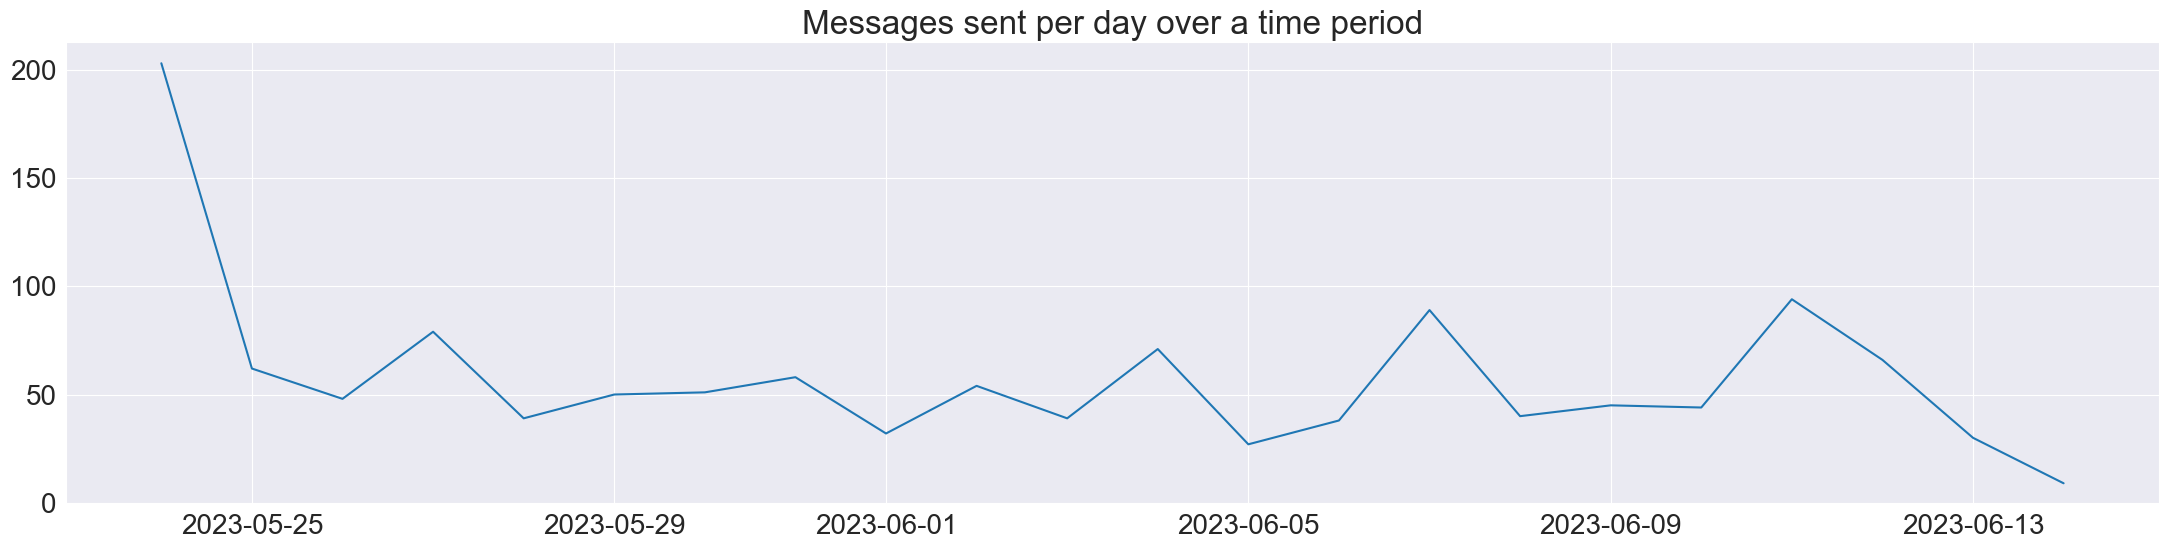

In [11]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   

# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# 2. Top 5 most active days.

In [12]:
top5days = df1.sort_values(by="message_count", ascending=False).head(5)    # Sort values according to the number of messages per day.
top5days.reset_index(inplace=True)           # reset index in order.
top5days.drop(columns="index", inplace=True) # dropping original indices.
top5days

,date,message_count
0,2023-05-24,203
1,2023-06-11,94
2,2023-06-07,89
3,2023-05-27,79
4,2023-06-04,71


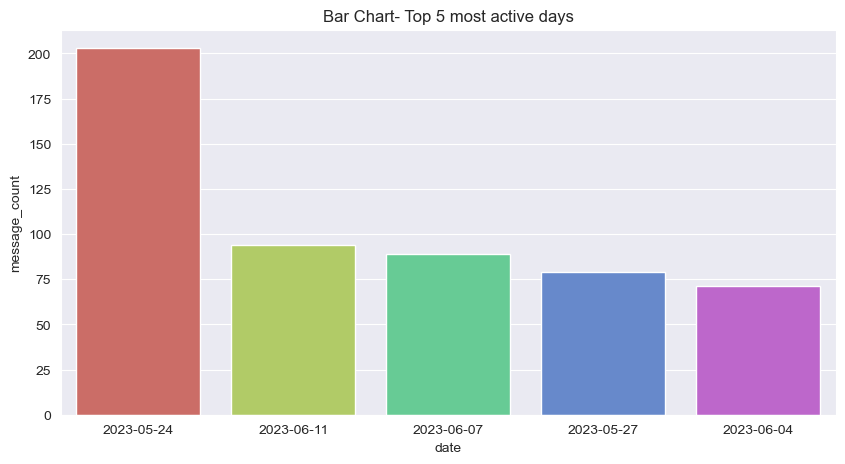

In [13]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readability
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (10, 5)

# A bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top5days, palette="hls")
plt.title('Bar Chart- Top 5 most active days');

# Saving the plots
plt.savefig('top5_days.svg', format = 'svg')

# 3. Top 10 active users on the group.

In [14]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 203
Number of people who haven't sent even a single message on the group are 32


### pre-processing top 10 active users.

In [15]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,+91 78290 20777,203
1,+91 98767 00680,82
2,+91 89852 08899,58
3,+91 89705 71155,47
4,+91 99860 10144,37
5,+91 88928 23783,35
6,+91 88842 78800,35
7,+91 91493 39093,25
8,+91 88661 38178,25
9,+91 88003 47002,24


### visualizing top 10 active users.

In [16]:
top10df['initials'] = ''
for i in range(10):
    
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
    top10df.initials[0] = "1st"    
    top10df.initials[1] = "2nd"
    top10df.initials[2] = "3rd"    
    top10df.initials[3] = "4th"
    top10df.initials[4] = "5th"    
    top10df.initials[5] = "6th"
    top10df.initials[6] = "7th"    
    top10df.initials[7] = "8th"
    top10df.initials[8] = "9th"    
    top10df.initials[9] = "10th"

In [17]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

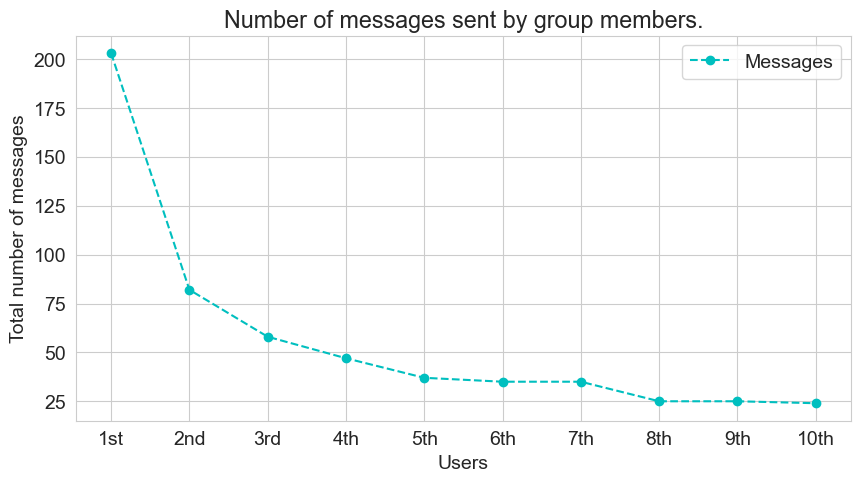

In [18]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(10, 5))

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  

# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

plt.savefig('msg_plots.svg', format = 'svg')

# Plotting a bar chart and line graph together

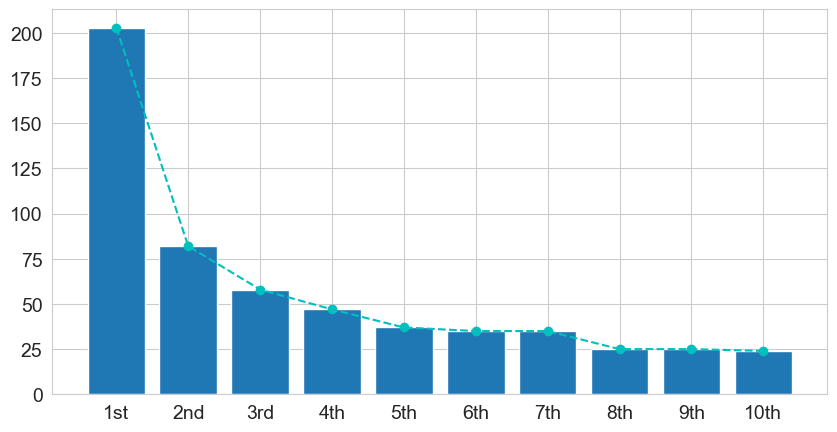

In [19]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(10, 5))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

# Beautifying Default Styles using Seaborn

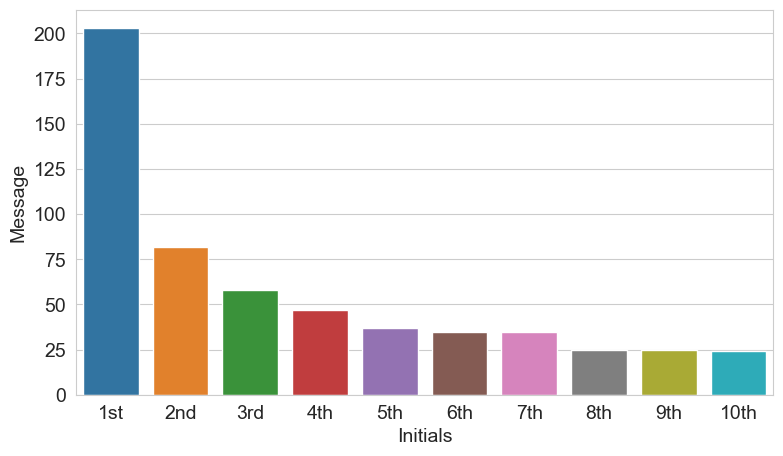

In [20]:
sns.barplot(data=top10df, x="initials", y="message")
plt.xlabel("Initials")
plt.ylabel("Message")
plt.show()

# maintain consistent colors for each person across all plots

In [21]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

{'1st': '#F94144',
 '2nd': '#F3722C',
 '3rd': '#F8961E',
 '4th': '#FDC500',
 '5th': '#ffafcc',
 '6th': '#90BE6D',
 '7th': '#43AA8B',
 '8th': '#577590',
 '9th': '#6D597A',
 '10th': '#0081a7'}

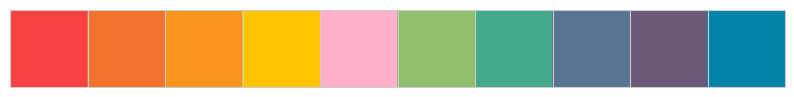

In [22]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#ffafcc', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#0081a7']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict


# Finding the average message length of the 10 most active users of the group.

In [23]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

# Plotting most sent messages and respective average message lengths.¶

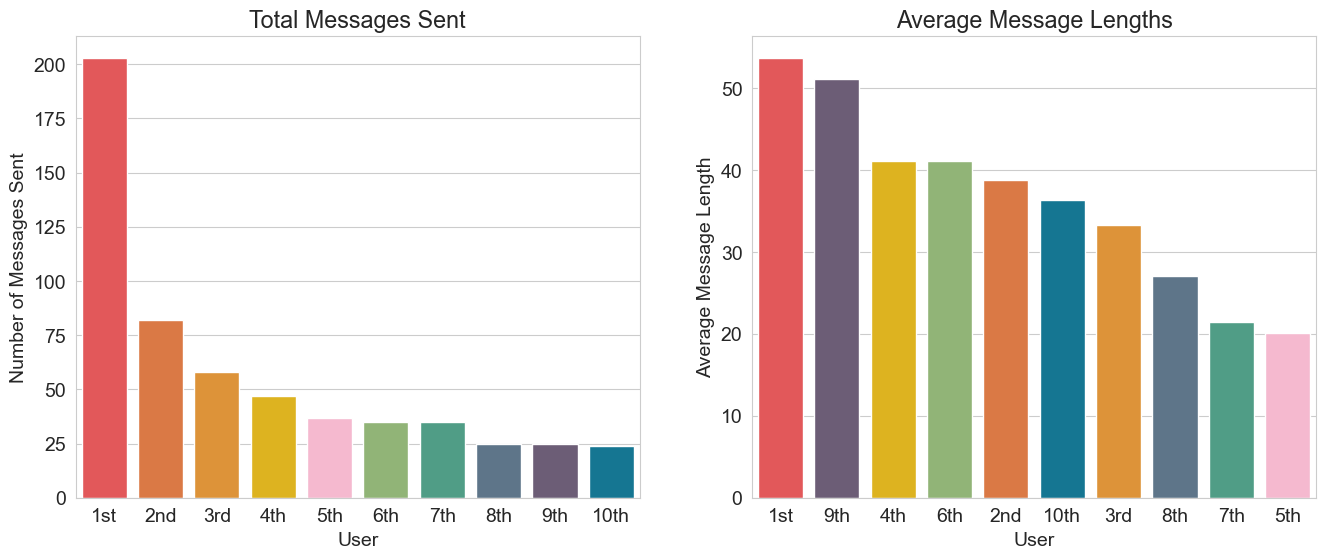

In [24]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")


# Plot 1 - Countplot of total messages sent
sns.barplot(data=top10df, x="initials", y="message", ax=axes[0], palette=get_colors_of_certain_order(top10df.initials))
axes[0].set_title('Total Messages Sent')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(data=top10df_msg, x="initials", y="avg_message_length", ax=axes[1], palette=get_colors_of_certain_order(top10df_msg.initials))
axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Message Length')

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format='svg')


# 4. Top 10 users most sent media

In [25]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

    top10df.initials[0] = "1st"    
    top10df.initials[1] = "2nd"
    top10df.initials[2] = "3rd"    
    top10df.initials[3] = "4th"
    top10df.initials[4] = "5th"    
    top10df.initials[5] = "6th"
    top10df.initials[6] = "7th"    
    top10df.initials[7] = "8th"
    top10df.initials[8] = "9th"    
    top10df.initials[9] = "10th" 
    

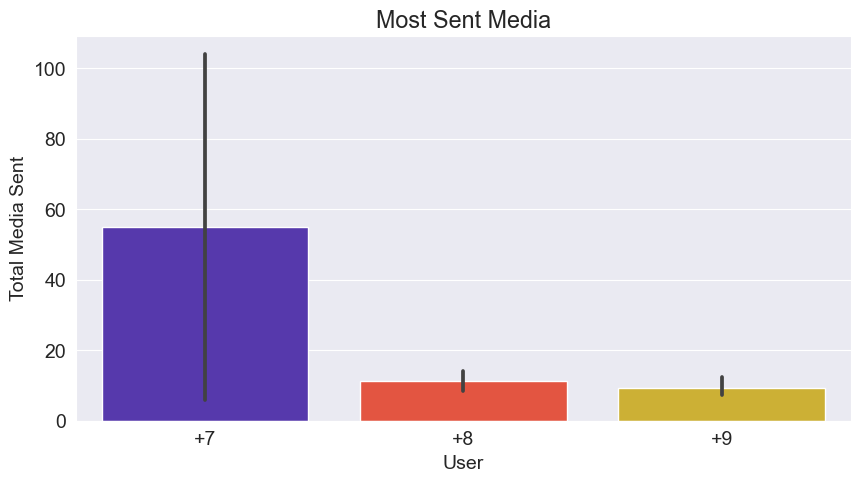

In [26]:
# Increasing the figure size
plt.figure(figsize=(10, 5))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(data=top10media, x="initials", y="media_sent", palette="CMRmap")

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent')

# Saving the plots
plt.savefig('top10media.svg', format='svg')

# 5. Top 10 most used Emojis

In [27]:
import re
from collections import Counter

emoji_ctr = Counter()
r = re.compile(r'([\U0001F300-\U0001F6FF])')

for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1


In [28]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,🙏,48,folded_hands
1,😊,40,smiling_face_with_smiling_eyes
2,🏻,28,light_skin_tone
3,🌅,27,sunrise
4,👍,26,thumbs_up
5,👌,22,OK_hand
6,🌸,15,cherry_blossom
7,🌼,15,blossom
8,🌞,14,sun_with_face
9,😀,12,grinning_face


# Most used emoji in chat

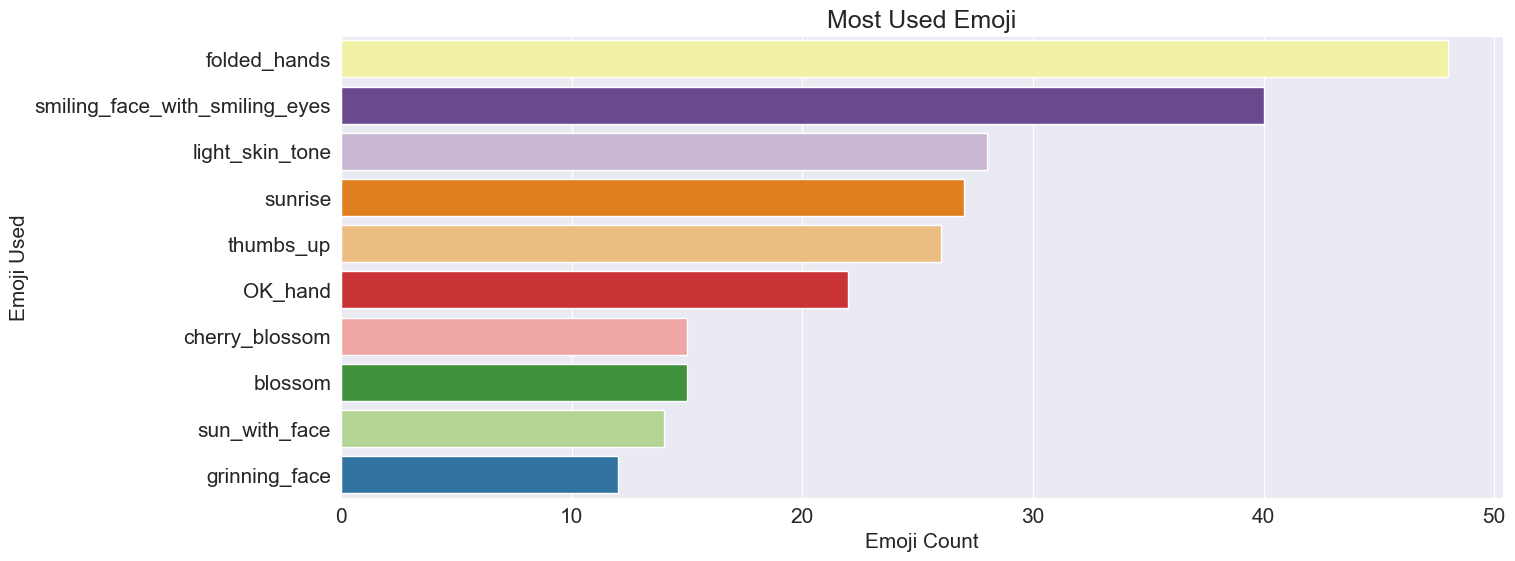

In [29]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting
sns.barplot(x='emoji_count', y='emoji_description', data=top10emojis, palette="Paired_r")
plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used')

# Saving the plot
plt.savefig('top10emoji.svg', format='svg')

# 6. Most active days, most active hours, most active months.

### Pre processig

In [30]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

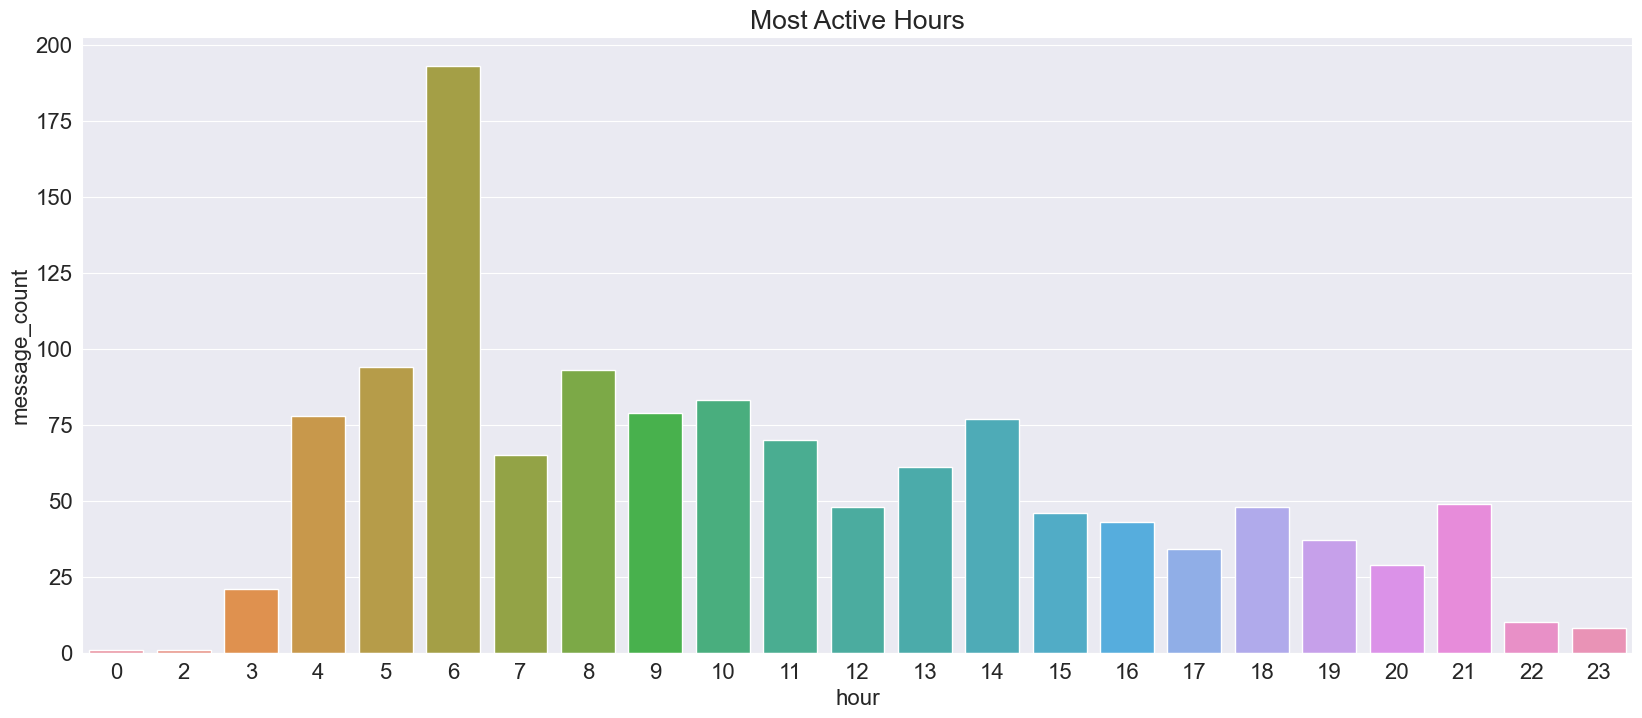

In [31]:
# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x='hour', y='message_count', data=grouped_by_time)
plt.title('Most Active Hours')

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

### pre-processing weekdays and months

In [32]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

### Visualization- plotting grouped by day and respective group by month simultaneously.

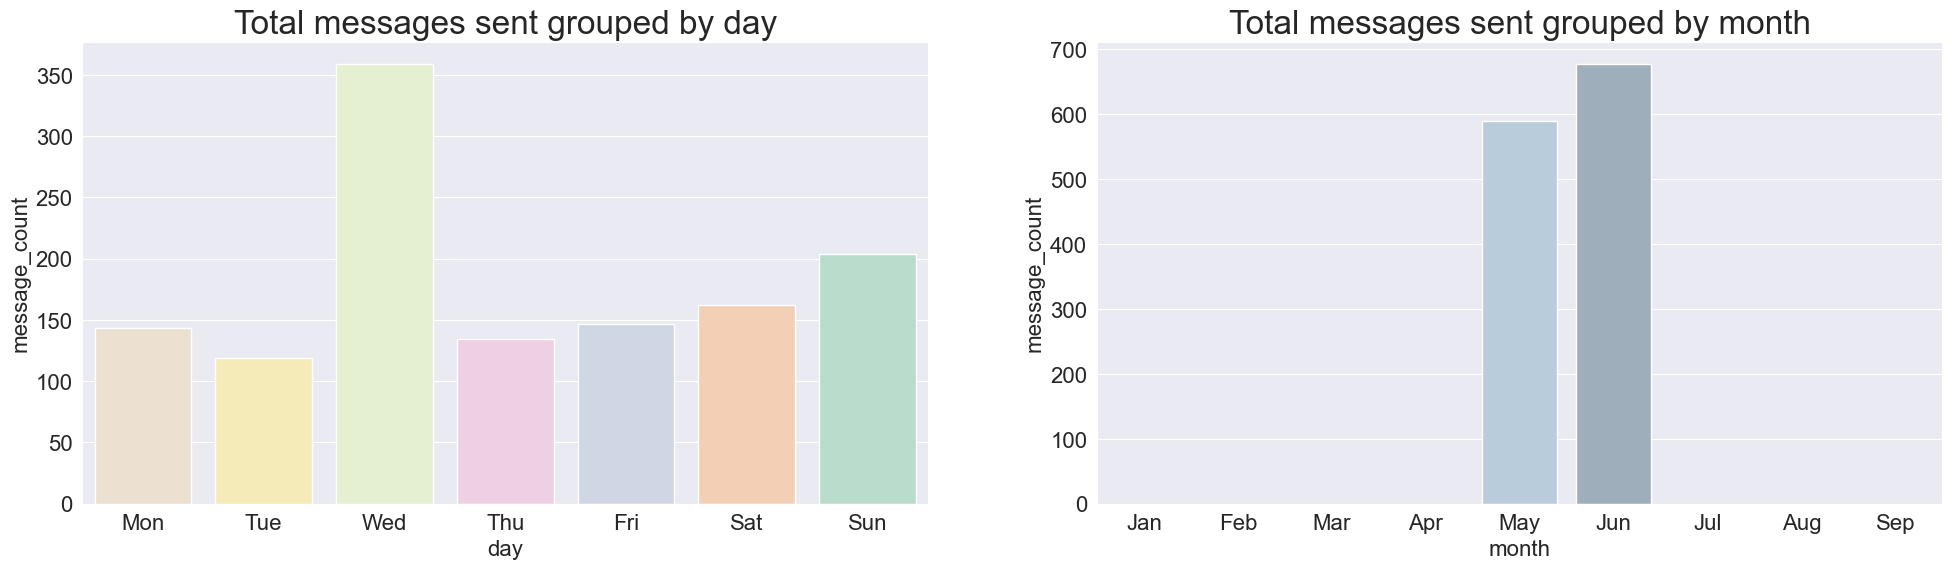

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count',data=grouped_by_day, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(x = grouped_by_month.month, y=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

### heatmap- combining the above to bar plots

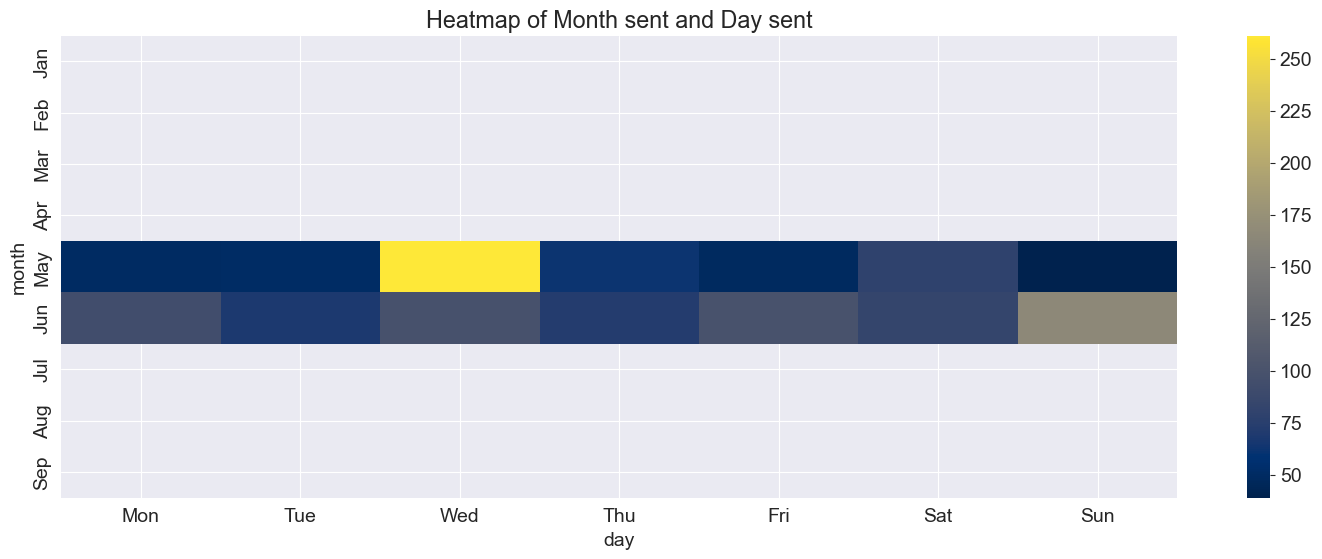

In [34]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

# Most used words in the chat.

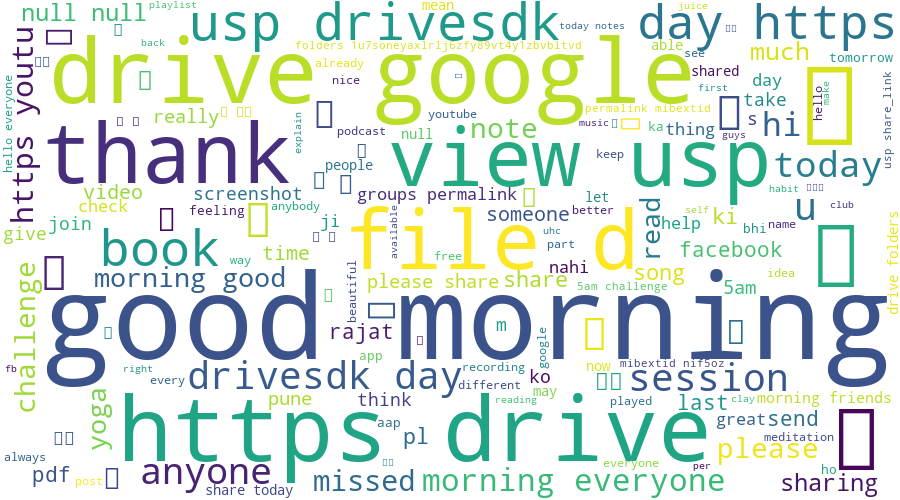

In [35]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 900, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 
wordcloud.to_image()